# Segmented regressions with exponential sampling and heteroscedastic noise

In [1]:
%load_ext autoreload
%autoreload 2
from pytree import *
import random
import matplotlib.pyplot as plt
import numpy

print(__version__)
print(__git_version__)

0.0.6
0207c346d12b5717c08a4166575845f618ea4ed3


In [2]:
min_x = 1
max_x = 1e9
nb_breakpoints = 6
size = 200
numpy.random.seed(27)
#breakpoints = list(sorted(numpy.exp(numpy.random.uniform(numpy.log(min_x), numpy.log(max_x), nb_breakpoints))))
breakpoints = [10**n for n in range(1, 9)]
print(f'Breakpoints: {breakpoints}')
x_list = list(sorted(numpy.exp(numpy.random.uniform(numpy.log(min_x), numpy.log(max_x), size))))
interval_idx = 0
y_list = []
tmp_break = breakpoints + [numpy.inf]
for i, x in enumerate(x_list):
    if x > tmp_break[interval_idx]:
        interval_idx += 1
    assert x <= tmp_break[interval_idx]
    slope = interval_idx*1e-10
    intercept = (interval_idx+1)*10*1e-10
    y_list.append(x*slope + intercept)
dataset = list(zip(x_list, y_list))

Breakpoints: [10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]


In [3]:
sigma = 0.1
noisy_dataset = [(x, y+numpy.random.normal(scale=sigma)*x*1e-10) for x, y in dataset]
x = [t[0] for t in noisy_dataset] 
x = numpy.array(x)
y = [t[1] for t in noisy_dataset] 
y = numpy.array(y)

## Top-down

Here, this is the usual stuff, we add breakpoints using a tree-like approach.

/home/tom/Dropbox/Documents/Fac/phd/pytree/pytree/reg.py:499: RuntimeWarning: invalid value encountered in double_scalars
  return self.cov_sum.mean * n / (n-1)


5
x ≤ 6.784e+03?
    └──x ≤ 9.808e+01?
    │    └──x ≤ 9.989e+00?
    │    │    └──y ~ 1.550e-12x + 9.865e-10
    │    │    └──y ~ 1.032e-10x + 1.824e-09
    │    └──y ~ 2.493e-10x + -5.002e-10
    └──x ≤ 9.923e+05?
         └──y ~ 4.456e-10x + -1.345e-12
         └──x ≤ 7.463e+06?
              └──y ~ 5.981e-10x + -9.552e-18
              └──y ~ 7.544e-10x + -1.256e-17
CPU times: user 8min 15s, sys: 55.7 ms, total: 8min 15s
Wall time: 8min 15s


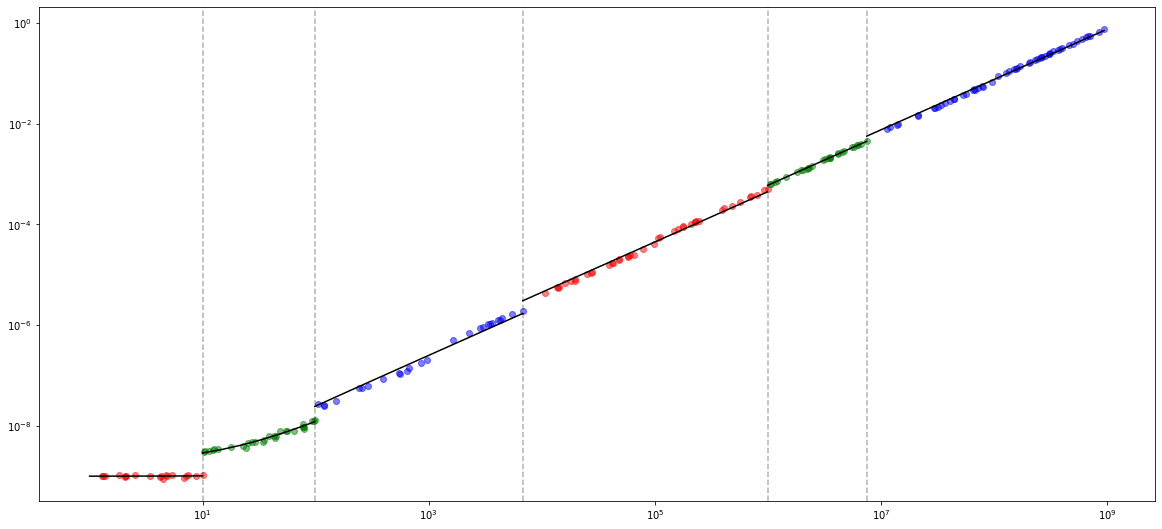

In [4]:
%%time
reg = compute_regression(x, y, mode='log')
print(len(reg.breakpoints))
print(reg)
reg.plot_dataset(log=True)

## Bottom-up

Here we remove breakpoints greedily, using the BIC.

In [5]:
%%time
reg.simplify()

CPU times: user 19.2 s, sys: 12 ms, total: 19.2 s
Wall time: 19.2 s


,regression,RSS,BIC,AIC,BIClog,RSSlog,weighted_RSS,weighted_BIC,nb_breakpoints
0,"((1.2765492834188505, 1.0053901099618097e-09),...",0.000647,-2406.388810,-2482.250110,503.439937,1.907893,3.204018e-19,-9454.744392,5
1,"((1.2765492834188505, 1.0053901099618097e-09),...",0.000731,-2403.110715,-2465.778745,680.907291,2.901196,7.826708e-19,-9297.310397,4
2,"((1.2765492834188505, 1.0053901099618097e-09),...",0.000731,-2424.303985,-2473.778745,1243.296479,5.819109,9.627447e-19,-9277.088452,3
3,"((1.2765492834188505, 1.0053901099618097e-09),...",0.000731,-2445.497254,-2481.778745,2276.271377,11.089949,1.300983e-18,-9238.064321,2
4,"((1.2765492834188505, 1.0053901099618097e-09),...",0.000811,-2446.093924,-2469.182146,3365.876818,16.643943,3.124219e-18,-9084.044692,1
5,"((1.2765492834188505, 1.0053901099618097e-09),...",0.000862,-2455.060274,-2464.955226,14318.600629,71.513528,1.137718e-17,-8846.752938,0


-inf < x ≤ 9.989e+00
	y ~ 1.550e-12x + 9.865e-10
9.989e+00 < x ≤ 9.808e+01
	y ~ 1.032e-10x + 1.824e-09
9.808e+01 < x ≤ 6.784e+03
	y ~ 2.493e-10x + -5.002e-10
6.784e+03 < x ≤ 9.923e+05
	y ~ 4.456e-10x + -1.345e-12
9.923e+05 < x ≤ 7.463e+06
	y ~ 5.981e-10x + -9.552e-18
7.463e+06 < x ≤ inf
	y ~ 7.544e-10x + -1.256e-17
CPU times: user 20.6 s, sys: 16 ms, total: 20.6 s
Wall time: 20.6 s


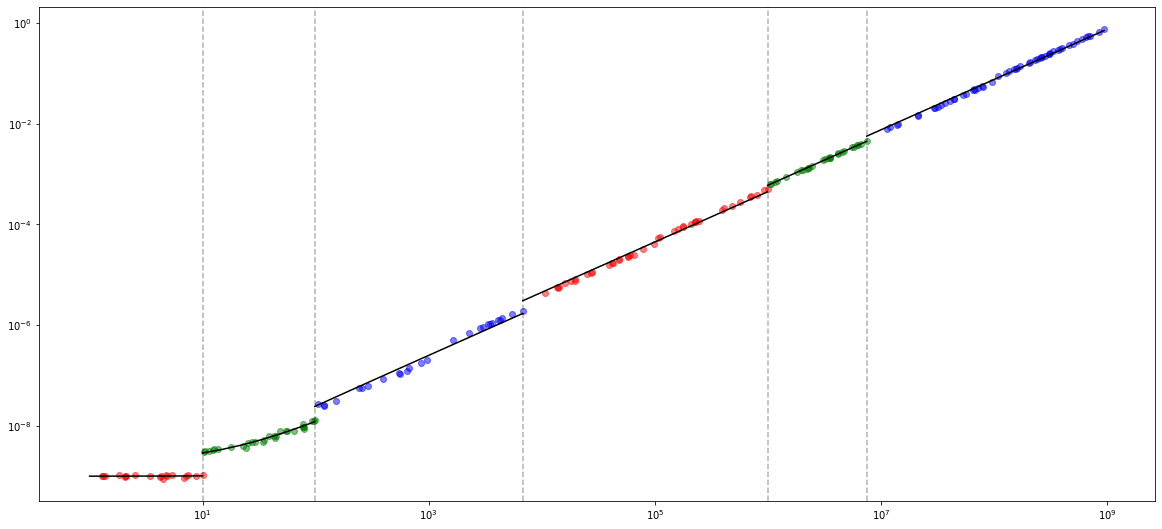

In [6]:
%%time
auto_simple = reg.auto_simplify()
print(auto_simple)
auto_simple.plot_dataset(log=True)

In [7]:
auto_simple.to_pandas()

,min_x,max_x,intercept,coefficient,RSS,MSE,RSSlog,weighted_RSS
0,-inf,9.989428e+00,9.865081e-10,1.550216e-12,3.060349e-20,1.530174e-21,0.032580,2.157638e-21
1,9.989428e+00,9.808278e+01,1.823558e-09,1.031856e-10,8.060818e-18,2.686939e-19,0.162585,4.806375e-21
2,9.808278e+01,6.784107e+03,-5.002184e-10,2.493148e-10,4.296976e-14,1.652683e-15,0.910685,5.712166e-20
3,6.784107e+03,9.923422e+05,-1.345061e-12,4.456084e-10,7.873796e-10,1.874713e-11,0.533879,1.080696e-19
4,9.923422e+05,7.463198e+06,-9.552107e-18,5.981095e-10,3.743471e-08,1.336954e-09,0.008437,3.025777e-21
5,7.463198e+06,inf,-1.256191e-17,7.543619e-10,6.471113e-04,1.198354e-05,0.259727,1.452208e-19
